<a href="https://colab.research.google.com/github/michaeljf00/projects_in_ml_and_ai/blob/main/homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework 5: CNNs, AEs, GANs-**

In your project, you will pick an image dataset to solve a classification task. Provide a link to
your dataset.

**Task 1 (70 points)**:

**Part 1 (20 points)**: This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt, image as img
from pathlib import Path
from os import makedirs
import shutil

In [50]:
batchSize = 32
imgSize = (128, 128)
SEED = 4906

Link to dataset: https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

In [51]:
df = pd.read_csv("drive/MyDrive/pokemon_hw8/pokemon.csv", encoding="utf-8")

In [52]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [53]:
df.shape

(809, 3)

There are 809 rows with three columns of information for each row.

To make the classification process easier, we will remove the second typing of the pokemon and use their main type (type1) as the target value.

In [54]:
df = df.drop('Type2', axis=1)
df.head()

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


In [55]:
len(df)

809

In [56]:
len(df.groupby('Type1').count())

18

In [57]:
df.value_counts("Type1")

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
dtype: int64

In [58]:
images = list(Path("drive/MyDrive/pokemon_hw8/pokemon_images/images").glob('*'))
labelledImages = {image.name[:-4]: image for image in images}
labelledImages

{'archen': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/archen.png'),
 'amoonguss': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/amoonguss.png'),
 'ampharos': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/ampharos.png'),
 'amaura': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/amaura.png'),
 'araquanid': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/araquanid.jpg'),
 'arceus': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/arceus.png'),
 'arbok': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/arbok.png'),
 'arcanine': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/arcanine.png'),
 'anorith': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/anorith.png'),
 'ambipom': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/ambipom.png'),
 'altaria': PosixPath('drive/MyDrive/pokemon_hw8/pokemon_images/images/altaria.png'),
 'aipom': PosixPath('drive/MyDrive/pokemon_hw8/pokem

With names of the pokemon parsed out of the dataset, we can the create the appropriate folders for each type and categorize each pokemon in their proper folder.

In [59]:
!mkdir -p pokemon

In [60]:
for pokemonType in df['Type1'].unique():
  new_dir = f'./pokemon/{pokemonType}'
  makedirs(new_dir, exist_ok=True)
  files = [labelledImages[name] for name in df[df['Type1'] == pokemonType]['Name']]
  for f in files:
    output = Path(f'{new_dir}/{f.name}')
    shutil.move(f, output)

In [61]:
dataPath = Path('/content/pokemon')

In [62]:
trainDS = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.3,
  label_mode='categorical',
  subset="training",
  seed=SEED,
  image_size=imgSize,
  batch_size=batchSize)

Found 809 files belonging to 18 classes.
Using 567 files for training.


In [63]:
valDS = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=SEED,
  image_size=imgSize,
  batch_size=batchSize)

Found 809 files belonging to 18 classes.
Using 161 files for validation.


In [64]:
cardinality = tf.data.experimental.cardinality(valDS)
halfed = cardinality//2
testDS = valDS.take(halfed)
valDS = valDS.skip(halfed)

In [65]:
types = trainDS.class_names
types

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

The model was able to recognize the 18 types which is evident from the 809 images split into 18 classes.

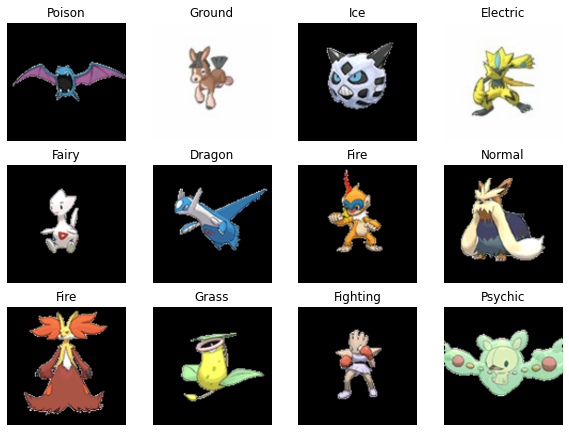

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in trainDS.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(types[np.argmax(labels[i])])
    plt.axis("off")

In [67]:
# Model Implementation

model = tf.keras.Sequential([
    
    # Input Layer
    tf.keras.layers.Resizing(256, 256, input_shape=(imgSize[0], imgSize[1], 3)),

    # Convolutional Layers
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(types))
])

In [68]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_100 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 64, 64, 32)       

In [69]:
history = model.fit(
            trainDS,
            validation_data=valDS,
            epochs=20
          )

Epoch 1/20
18/18 [==============================] - 29s 2s/step - loss: 39.5559 - accuracy: 0.0653 - val_loss: 3.2677 - val_accuracy: 0.0615
Epoch 2/20
18/18 [==============================] - 29s 2s/step - loss: 2.8490 - accuracy: 0.1076 - val_loss: 2.8307 - val_accuracy: 0.1231
Epoch 3/20
18/18 [==============================] - 28s 2s/step - loss: 2.5878 - accuracy: 0.1869 - val_loss: 2.8622 - val_accuracy: 0.1077
Epoch 4/20
18/18 [==============================] - 28s 2s/step - loss: 2.2946 - accuracy: 0.2540 - val_loss: 2.9405 - val_accuracy: 0.1231
Epoch 5/20
18/18 [==============================] - 28s 2s/step - loss: 2.0027 - accuracy: 0.3316 - val_loss: 2.8896 - val_accuracy: 0.0769
Epoch 6/20
18/18 [==============================] - 28s 2s/step - loss: 1.7832 - accuracy: 0.4145 - val_loss: 3.0063 - val_accuracy: 0.1231
Epoch 7/20
18/18 [==============================] - 28s 2s/step - loss: 1.5220 - accuracy: 0.5062 - val_loss: 2.8433 - val_accuracy: 0.1692
Epoch 8/20
18/18 [=

In [70]:
loss, accuracy = model.evaluate(testDS)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

3/3 [==============================] - 2s 490ms/step - loss: 4.4968 - accuracy: 0.1667
Test loss: 4.496799468994141, Test accuracy: 0.1666666716337204


The pokemon were designed purposefully to have certain traits match the assigned types. For example, the pokemon gloomish resembles that of a plant and has a flower like structure on top of its head, signifying it is a grass type pokemon. Another example would be squirtle where its shape and characteristics were modeled after a turtle which is an amphibious createure. Along with this, it has a blue color, strongly correlating itself to being a water type. Many of the pokemon within a certain type category share much similarities and it would be essential for these patterns to be discovered by the model. 

The implementation had 3 convolutional, pooling and dense layers. Even with the change in hyperparemeters and playing with values, the performance is far from satisfactory. The loss is at a high value and the test accuracy is at an extremely low 6%. This is a complicated problem since it does need to categorize the pokemon into 18 clasesses. Most likely it is difficult for this model to generalize with this manny options and it is problably going through much overfitting too.

**Part 2 (25 points)**: The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)

Choose any **one** of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not?

In [71]:
size = imgSize[0]
googleInception = tf.keras.applications.inception_v3.InceptionV3(
  include_top=False,
  input_shape=(size, size, 3),
  weights='imagenet'
)

In [72]:
input = tf.keras.Input((size, size, 3))
x = tf.keras.applications.inception_v3.preprocess_input(input)
x = googleInception(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(types))(x)
model = tf.keras.Model(input, output)

In [73]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [74]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [75]:
history = model.fit(
            trainDS,
            validation_data=valDS,
            epochs=12
          )

Epoch 1/12
18/18 [==============================] - 108s 6s/step - loss: 2.9538 - accuracy: 0.1429 - val_loss: 21.1632 - val_accuracy: 0.1692
Epoch 2/12
18/18 [==============================] - 99s 5s/step - loss: 2.5245 - accuracy: 0.2504 - val_loss: 27.8394 - val_accuracy: 0.0923
Epoch 3/12
18/18 [==============================] - 97s 5s/step - loss: 2.2087 - accuracy: 0.3245 - val_loss: 538.8924 - val_accuracy: 0.1385
Epoch 4/12
18/18 [==============================] - 98s 5s/step - loss: 1.8877 - accuracy: 0.4409 - val_loss: 21.9462 - val_accuracy: 0.0462
Epoch 5/12
18/18 [==============================] - 99s 5s/step - loss: 1.4361 - accuracy: 0.5820 - val_loss: 4.3238 - val_accuracy: 0.1231
Epoch 6/12
18/18 [==============================] - 98s 5s/step - loss: 1.1382 - accuracy: 0.6984 - val_loss: 4.3346 - val_accuracy: 0.2000
Epoch 7/12
18/18 [==============================] - 98s 5s/step - loss: 0.9642 - accuracy: 0.7407 - val_loss: 16.3074 - val_accuracy: 0.1077
Epoch 8/12
18

In [76]:
loss, accuracy = model.evaluate(testDS)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

3/3 [==============================] - 3s 905ms/step - loss: 16.2591 - accuracy: 0.2188
Test loss: 16.25908851623535, Test accuracy: 0.21875


The Inception V3 model by Google performaed much better with a way higher accuracy. Overfitting is still occurring but, this pretrained model was given a sufficient amount of quality data to give a better performance overall. This is definitely a big improvement compared to the last model. 

**Part 3 (25 points)**:  Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

In [77]:
model = tf.keras.Sequential([

  # Input Layer
  tf.keras.layers.Resizing(256, 256, input_shape=(size, size, 3)),

  # Random Flip and Rotation
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),

  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Rescaling(1./255),

  # Convolutional Layers
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  # Dense Layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(len(types))

])

In [78]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [79]:
history = model.fit(
            trainDS,
            validation_data=valDS,
            epochs=20
          )

Epoch 1/20
18/18 [==============================] - 35s 2s/step - loss: 2.8309 - accuracy: 0.0935 - val_loss: 2.7579 - val_accuracy: 0.1538
Epoch 2/20
18/18 [==============================] - 34s 2s/step - loss: 2.7695 - accuracy: 0.1358 - val_loss: 2.7420 - val_accuracy: 0.0923
Epoch 3/20
18/18 [==============================] - 34s 2s/step - loss: 2.7504 - accuracy: 0.1270 - val_loss: 2.7891 - val_accuracy: 0.1538
Epoch 4/20
18/18 [==============================] - 33s 2s/step - loss: 2.7430 - accuracy: 0.1235 - val_loss: 2.7316 - val_accuracy: 0.1231
Epoch 5/20
18/18 [==============================] - 34s 2s/step - loss: 2.6861 - accuracy: 0.1517 - val_loss: 2.5250 - val_accuracy: 0.2462
Epoch 6/20
18/18 [==============================] - 35s 2s/step - loss: 2.6491 - accuracy: 0.1834 - val_loss: 2.5462 - val_accuracy: 0.3077
Epoch 7/20
18/18 [==============================] - 34s 2s/step - loss: 2.5994 - accuracy: 0.1887 - val_loss: 2.6493 - val_accuracy: 0.1692
Epoch 8/20
18/18 [==

In [80]:
loss, accuracy = model.evaluate(testDS)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

3/3 [==============================] - 2s 494ms/step - loss: 2.6226 - accuracy: 0.2396
Test loss: 2.6225855350494385, Test accuracy: 0.2395833283662796


With the augmented model, the performance was even better compared to previous two. The accuracy is at 0.27 which is most likely the highest is can be. With more configuration, its performance can probably be boosted a slight amount but the implementations run time still takes a considerable amount. Overfitting is definitely still occurring most likely due to an uneven spread of the classified types of the pokemon.

**Task 2 (30 points)**:

**Part 1 (15 points)**: Variational Autoencoder (VAE): Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

In [95]:
def preprocess_images(images):
  images = images/255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [96]:
trainImages = np.concatenate([x for x, y in trainDS], axis=0)
testImages = np.concatenate([x for x, y in valDS], axis=0)

In [97]:
trainImages = preprocess_images(trainImages)
testImages = preprocess_images(testImages)

In [98]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(size, size, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32**3, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [99]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [100]:
epochs = 20
latent_dim = 200
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [101]:
trainSize = 60000
batchSize = 32
testSize = 10000

trainDataset = (tf.data.Dataset.from_tensor_slices(trainImages)
                 .shuffle(trainSize).batch(batchSize))
testDataset = (tf.data.Dataset.from_tensor_slices(testImages)
                .shuffle(testSize).batch(batchSize))

In [102]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Pick a sample of the test set for generating output images
assert batchSize >= num_examples_to_generate
for test_batch in testDataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 20, Test set ELBO: -12348.4736328125, time elapse for current epoch: 22.467506408691406


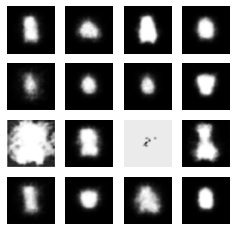

In [103]:
import time
from IPython import display

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in trainDataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in testDataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

**Part 2 (15 points)**: Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan

In [104]:
images = np.concatenate([image for image, _ in trainDS], axis=0)
labels = np.concatenate([label for _, label in trainDS], axis=0)

In [105]:
batchSize = 64